In [20]:
#Source Data Libraries
import yfinance as yf  
from pandas_datareader import data as wb #No longer useful for Yahoo Finance

#Useful Libraries
from datetime import date, timedelta
import pandas as pd
import numpy as np

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from tqdm import tqdm
%matplotlib inline


#### INPUTS TO BEGIN

In [45]:
tickers = ["META", "NFLX"]
data = yf.download(tickers, auto_adjust=False)
# df["Close"]

[*********************100%***********************]  2 of 2 completed

2 Failed downloads:
['META', 'NFLX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [ ]:
start_date='2015-01-01'
assets=['VOO','NVDA','MSFT','AAPL','AMD','TSLA','BRK-B','GOOG','SLB','KO','AMZN','^VIX']
assets_prices = [a for a in assets if a != '^VIX']


prices = yf.download(
    assets,
    start="2024-01-01",
    auto_adjust=False,
    progress=False
)['Close']

log_returns = np.log(prices / prices.shift(1))

log_returns = np.log(prices).diff()

log_returns = log_returns.dropna()

# Correlation matrix
corr = log_returns.corr()

# Normalize prices (start at 100)
norm_prices = (prices / prices.iloc[0]) * 100


12 Failed downloads:
['AMD', 'TSLA', 'AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'VOO', 'BRK-B', '^VIX', 'KO', 'SLB']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


IndexError: single positional indexer is out-of-bounds

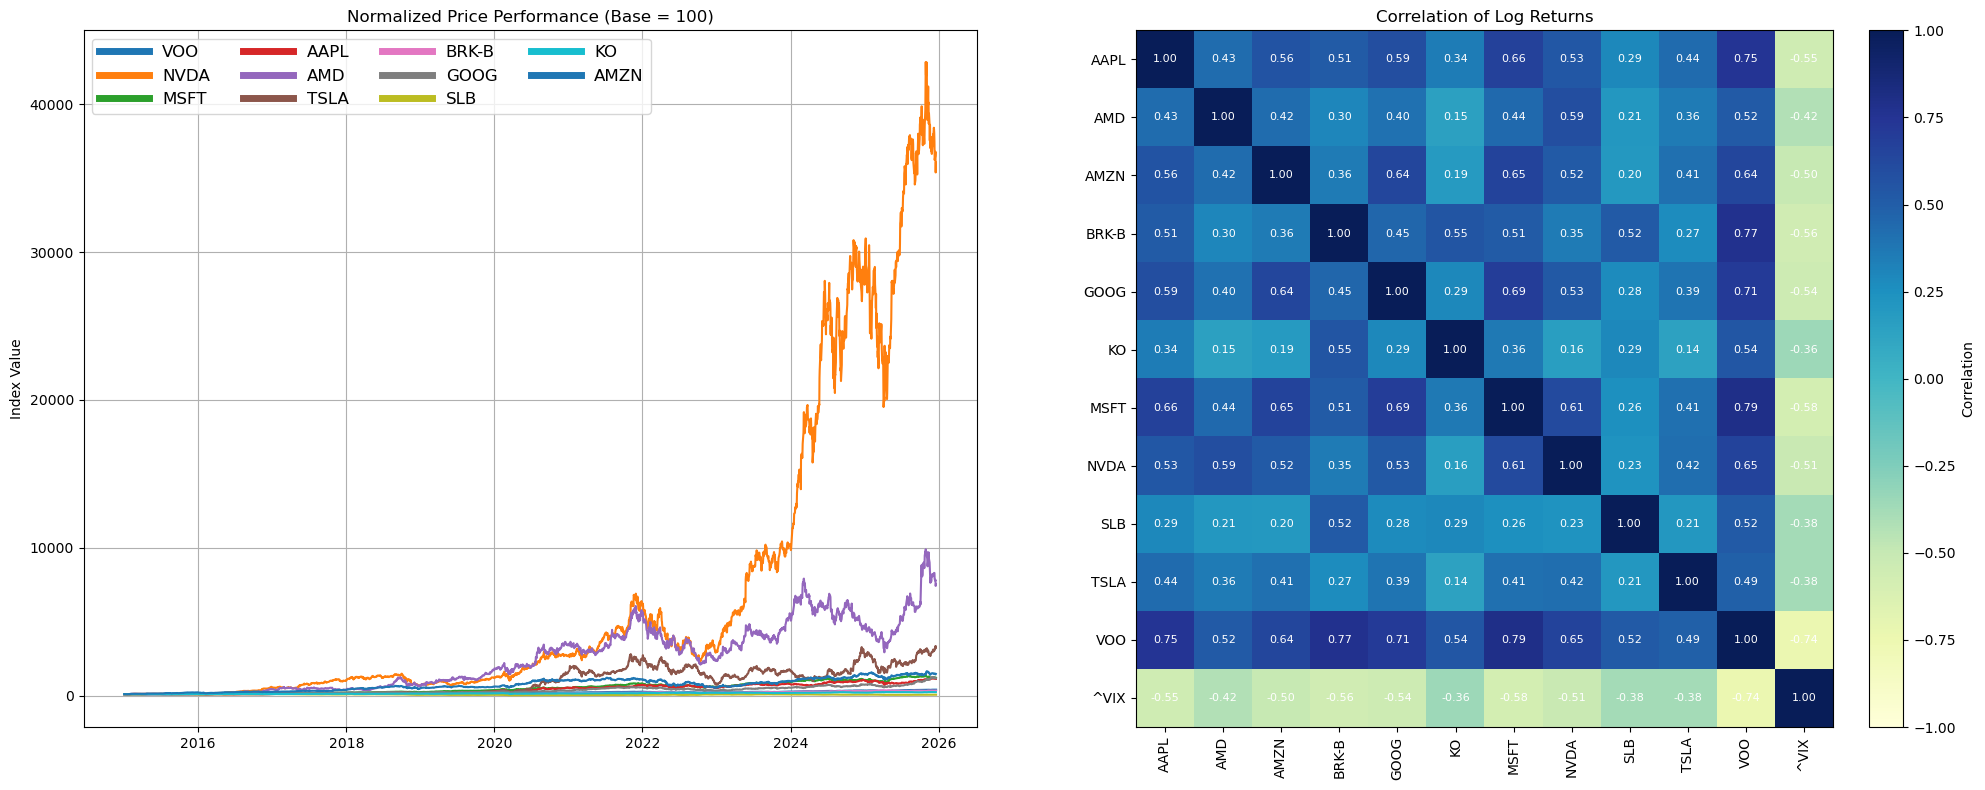

In [ ]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# -----------------------
# LEFT: Prices (NO VIX)
# -----------------------
for stk in assets_prices:
    ax1.plot(norm_prices.index, norm_prices[stk], label=stk)


ax1.set_title("Normalized Price Performance (Base = 100)")
ax1.set_ylabel("Index Value")
leg = ax1.legend(ncol=4, fontsize=12,handlelength=3,markerscale=10)
for line in leg.get_lines():
    line.set_linewidth(5)
ax1.grid(True)

# -----------------------
# RIGHT: Correlation (WITH VIX)
# -----------------------
im = ax2.imshow(corr, cmap="YlGnBu", vmin=-1, vmax=1)

ax2.set_xticks(range(len(corr.columns)))
ax2.set_yticks(range(len(corr.columns)))
ax2.set_xticklabels(corr.columns, rotation=90)
ax2.set_yticklabels(corr.columns)

ax2.set_title("Correlation of Log Returns")

cbar = fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label("Correlation")

for i in range(len(corr)):
    for j in range(len(corr)):
        ax2.text(j, i, f"{corr.iloc[i, j]:.2f}",
                 ha="center", va="center", color="white", fontsize=8)

plt.tight_layout()
plt.show()


Rolling correlation (time-varying)

In [18]:
rolling_corr = log_returns['AAPL'].rolling(252).corr(log_returns['MSFT'])


Robust correlation (less outlier-sensitive)

In [19]:
corr_spearman = log_returns.corr(method="spearman")

Shrinkage (portfolio optimization)

In [20]:
from sklearn.covariance import LedoitWolf

lw = LedoitWolf().fit(log_returns)
shrunk_corr = pd.DataFrame(
    lw.covariance_ / np.outer(np.sqrt(np.diag(lw.covariance_)), np.sqrt(np.diag(lw.covariance_))),
    index=log_returns.columns,
    columns=log_returns.columns
)
